In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [192]:
import seaborn as sns
sns.set()
import pandas as pd
from pandas import DataFrame, Series
from scipy.fftpack import fft
from scipy.signal import convolve
import numba
from scipy import stats
import sys
import imp
if '/Share/home/shibinbin/projects/DeepShape/bin' not in sys.path:
    sys.path.append('/Share/home/shibinbin/projects/DeepShape/bin')

In [229]:
def read_coverage(filename):
    coverage = []
    gene_ids = []
    with open(filename, 'r') as f:
        for line in f:
            c = line.strip().split('\t')
            gene_id = c[0]
            values = np.array(c[1:]).astype(np.float64)
            gene_ids.append(gene_id)
            coverage.append(values)
    return gene_ids, coverage

def call_peak(x, width=11):
    width = min(width, len(x))
    filter = np.full(width, 1.0/width)
    bg = convolve(x, filter, mode='same')
    bg[np.isclose(bg, 0)] = 1
    snr = x/bg
    return (snr > 1.0).astype(np.int32)

def histogram_matrix(signals, use_log=False, bins=50):
    if use_log:
        signals = [np.log10(np.maximum(a, 0.001)) for a in signals]
    all_values = np.concatenate(signals)
    min_val, max_val = all_values.min(), all_values.max()
    bins = np.linspace(np.percentile(all_values, 1),
                       np.percentile(all_values, 99), bins + 1, endpoint=True)
    bin_indices = np.arange(len(bins)).reshape((1, -1))

    m = np.row_stack([np.sum(np.digitize(a, bins)[:, np.newaxis] == bin_indices, axis=0) for a in signals])
    m = m.astype(np.float64)
    m_scale = np.sum(m, axis=1, keepdims=True)
    mask = ~np.isclose(m_scale, 0).flatten()
    m_scale[np.isclose(m_scale, 0)] = 1
    m /= m_scale
    m = m[mask]
    return m, bins

def plot_coverage(gene_ids, cov, indices=30, need_call_peak=False):
    df = []
    if type(indices) is int:
        indices = range(indices)
    for i in indices:
        x = cov[i]
        if need_call_peak:
            x = call_peak(x)
        df_g = pd.DataFrame({'coverage': x})
        df_g['gene_id'] = gene_ids[i]
        df_g['position'] = np.arange(len(x))
        #df_g['position'] = np.linspace(0, 1, len(cov[dataset][i]), endpoint=True)
        df.append(df_g)
    df = pd.concat(df, axis=0)
    g = sns.FacetGrid(data=df, row="gene_id", 
                      row_order=df['gene_id'].unique(), 
                      size=0.8, aspect=16, sharey=False)
    g = g.map(plt.plot, 'position', 'coverage', drawstyle='steps', linewidth=1.0)

In [240]:
np.median(np.concatenate(signals['exRNA_rpkm']))

0.0

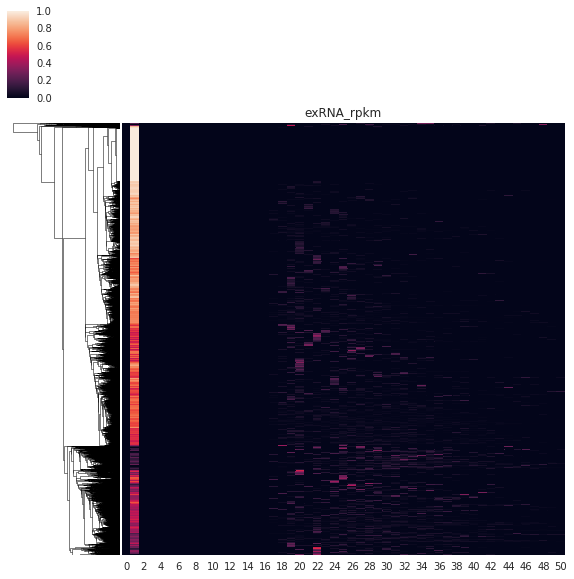

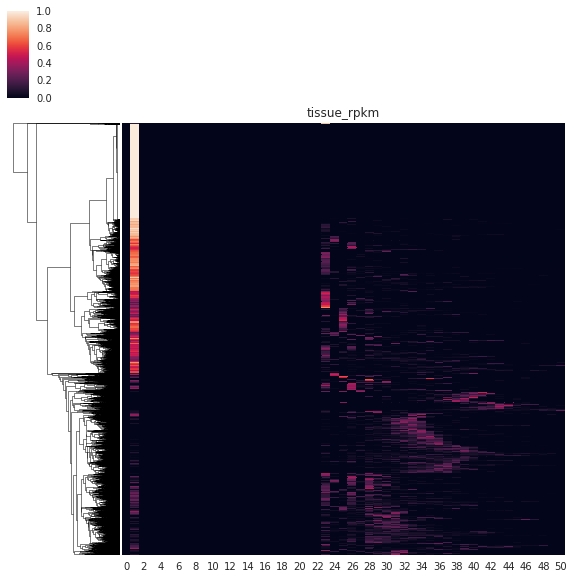

In [238]:
for dataset in ('exRNA_rpkm', 'tissue_rpkm'):
    m_hist, bins = histogram_matrix(signals[dataset], use_log=True)
    g = sns.clustermap(m_hist[:5000], row_cluster=True, col_cluster=False)
    g.ax_heatmap.set_yticks([])
    g.ax_heatmap.set_title(dataset)

In [5]:
signals = {}
gene_ids = {}
gene_ids['exRNA_fraction'], signals['exRNA_fraction'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/filt/candidate_all_mean.bedgraph.ratio_filt0.3')
gene_ids['exRNA_fraction'], signals['tissue_fraction'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/filt/candidate_all_mean.tissue.bedgraph.ratio_filt0.3')
gene_ids['exRNA_rpkm'], signals['exRNA_rpkm'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/bedgraph/candidate_all_mean.bedgraph')
gene_ids['tissue_rpkm'], signals['tissue_rpkm'] = read_coverage('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/no_mRNA/pheatmap/bedgraph/candidate_all_mean.tissue.bedgraph')

Text(0.5,1,'Smoothed peaks')

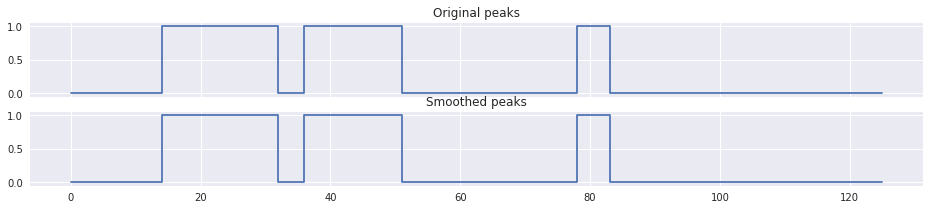

In [87]:
@numba.jit('int64(int32[:], int32[:], float64, float64, float64)')
def icm_update(x, y, h=0.0, beta=1.0, eta=2.1):
    n_changes = 0
    N = x.shape[0]
    for i in range(N):
        dx = -2*x[i]
        dE = 0
        if i > 0:
            dE += h*dx - beta*dx*x[i - 1] - eta*dx*y[i]
        if i < (N - 1):
            dE += h*dx - beta*dx*x[i + 1] - eta*dx*y[i]
        if dE < 0:
            x[i] = -x[i]
            n_changes += 1
    return n_changes
        
def icm_smooth(x, h=0.0, beta=1.0, eta=2.1):
    '''Smooth signals using iterated conditional modes
    Args:
        x: 1D signal
    Returns:
        Smoothed signal of the same length of x
    '''
    x = x*2 - 1
    y = x.copy()
    #E = h*np.sum(x) - beta*x[:-1]*x[1:] - eta*x*y
    n_updates = icm_update(x, y, h=h, beta=beta, eta=eta)
    while n_updates > 0:
        n_updates = icm_update(x, y, h=h, beta=beta, eta=eta)
    x = (x > 0).astype(np.int32)
    return x

x = df.loc[df['Name'] == 'peak (width=5)', 'Signal'].values
x = x.astype(np.int32)
fig, axes = plt.subplots(2, 1, figsize=(16, 3), sharex=True, sharey=True)
axes[0].plot(np.arange(len(x)), x, drawstyle='steps')
axes[0].set_title('Original peaks')
y = icm_smooth(x, h=0.0, beta=5.0, eta=2.0)
axes[1].plot(np.arange(len(y)), y, drawstyle='steps')
axes[1].set_title('Smoothed peaks')

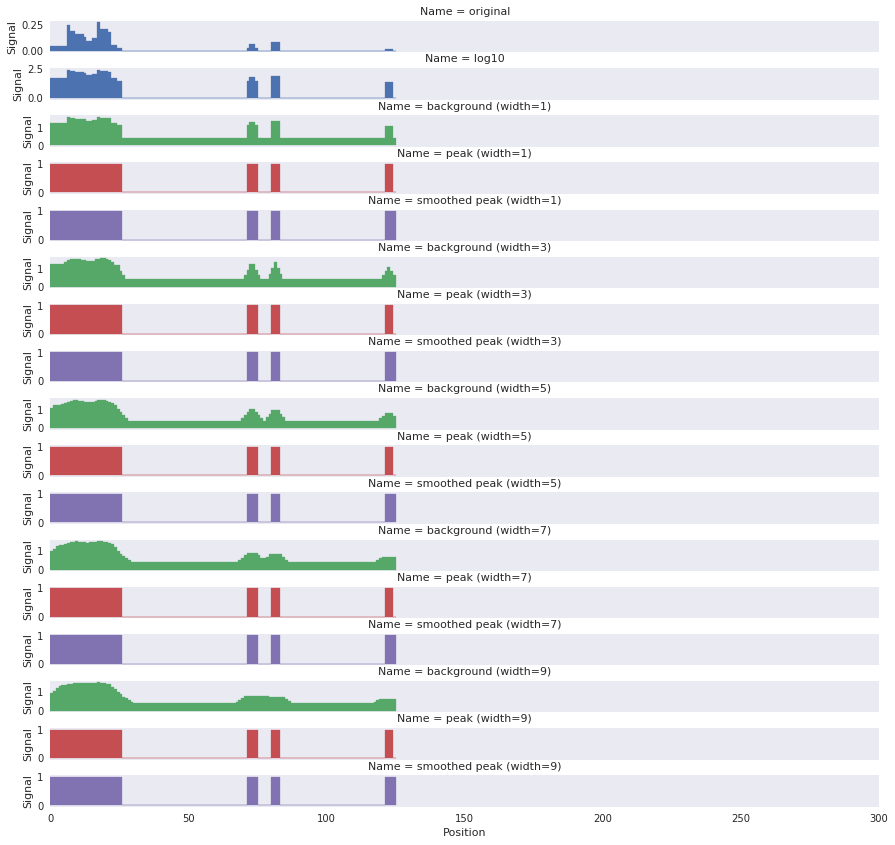

In [302]:
sig = signals['exRNA_rpkm'][10]
df = []
positions = np.arange(len(sig))
df.append(DataFrame({'Position': positions, 'Signal': sig, 'Name': 'original',
                     'Color': np.full(len(sig), 0, dtype=np.int32)}))
sig = np.log10(np.clip(sig, 1e-3, 1e5)) + 3
df.append(DataFrame({'Position': positions, 'Signal': sig, 'Name': 'log10',
                     'Color': np.full(len(sig), 0, dtype=np.int32)}))

logrpkm_mean = np.array([np.mean(np.log10(np.maximum(a, 0.001))) for a in signals['exRNA_rpkm']])
logrpkm_mean_nonzero = logrpkm_mean[~np.isclose(logrpkm_mean, -3)]
bg_global = np.median(logrpkm_mean_nonzero) + 3
#bg_global = np.mean(sig)

for i in range(5):
    width = 2*i + 1
    filter = np.full(width, 1.0/width)
    #filter = signal.gaussian(50, std=width)
    #axes[i + 1].plot(convolve(sig, filter, mode='same'))
    #axes[i + 1].set_title(str(width))
    bg_local = convolve(sig, filter, mode='same')
    bg = 0.5*(bg_local + bg_global)
    bg[np.isclose(bg, 0)] = 1
    snr = sig/bg
    peaks = (snr > 1.0).astype(np.int32)
    smoothed_peaks = icm_smooth(peaks, h=-2.0, beta=4.0, eta=2.0)
    df.append(DataFrame({'Position': positions,
                         'Signal': bg,
                         'Name': np.full(len(sig), 'background (width={})'.format(width)),
                         'Color': np.full(len(sig), 1, dtype=np.int32)}))
    df.append(DataFrame({'Position': positions,
                         'Signal': peaks,
                         'Name': np.full(len(sig), 'peak (width={})'.format(width)),
                         'Color': np.full(len(sig), 2, dtype=np.int32)}))
    df.append(DataFrame({'Position': positions,
                         'Signal': smoothed_peaks,
                         'Name': np.full(len(sig), 'smoothed peak (width={})'.format(width)),
                         'Color': np.full(len(sig), 3, dtype=np.int32)}))

df = pd.concat(df, axis=0)
sns.set_style("dark")
g = sns.FacetGrid(df, row='Name', hue='Color', row_order=df['Name'].unique(), size=0.7, aspect=18, sharey=False, 
                  xlim=(0, 300))
#g.map(plt.plot, 'Position', 'Signal', drawstyle='steps', linewidth=1.0)
g.map(plt.fill_between, 'Position', 'Signal', step='pre', edgecolor='none')
g.fig.subplots_adjust(hspace=0.5)

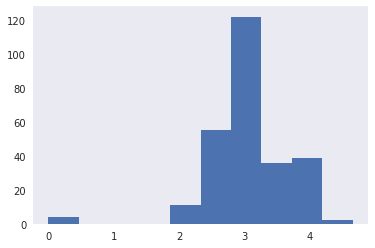

In [284]:
h = hist(sig, bins=10)

Gamma(a=4.48, loc=0.00, scale=0.68, mean = 3.06, std = 1.45, Q05 = 1.13, Q95 = 4.17)


(0, 5)

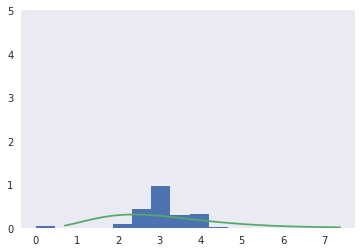

In [285]:
a, loc, scale = stats.gamma.fit(np.maximum(sig, 0.001), floc=0.0)
x = np.linspace(stats.gamma.ppf(0.01, a, loc, scale),
                stats.gamma.ppf(0.99, a, loc, scale), 100)
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(sig, bins=10, normed=True)
ax.plot(x, stats.gamma.pdf(x, a, loc, scale))
print('Gamma(a={:.2f}, loc={:.2f}, scale={:.2f}, mean = {:.2f}, std = {:.2f}, Q05 = {:.2f}, Q95 = {:.2f})'.format(
    a, loc, scale, stats.gamma.mean(a, loc, scale), stats.gamma.std(a, loc, scale),
    stats.gamma.ppf(0.05, a, loc, scale), stats.gamma.ppf(0.80, a, loc, scale)))
ax.set_ylim(0, 5)

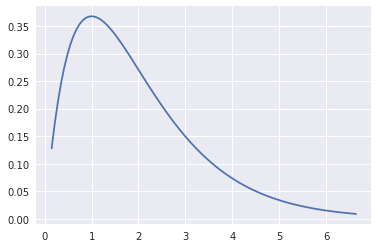

In [181]:
a = 2.0
x = np.linspace(stats.gamma.ppf(0.01, a),
                stats.gamma.ppf(0.99, a), 100)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, stats.gamma.pdf(x, a))

In [184]:
stats.gamma.fit_loc_scale(sig)

TypeError: _parse_args_stats() missing 1 required positional argument: 'a'

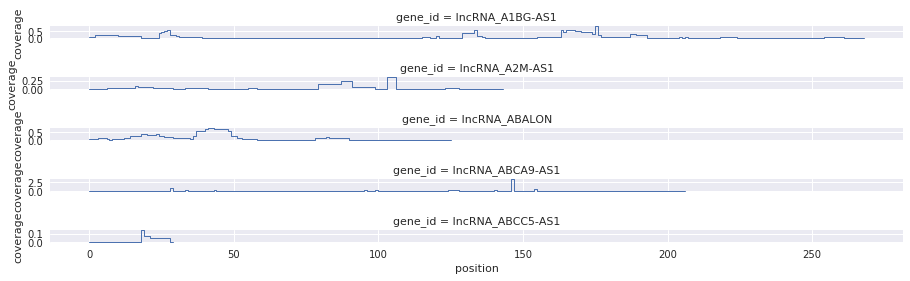

In [15]:
plot_coverage(gene_ids['exRNA_rpkm'], signals['exRNA_rpkm'], indices=5, need_call_peak=False)

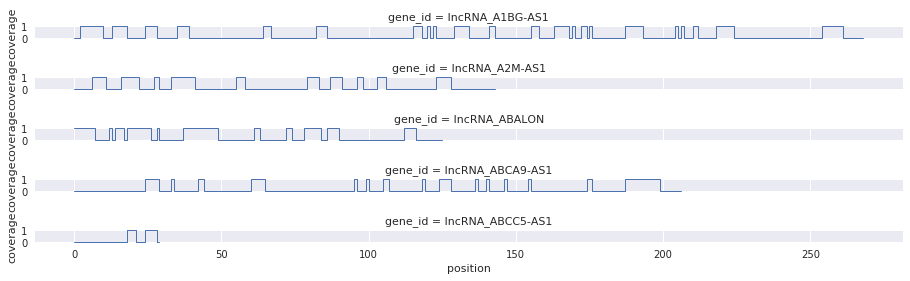

In [14]:
plot_coverage(gene_ids['exRNA_rpkm'], signals['exRNA_rpkm'], indices=5, need_call_peak=True)

a=1.5114039807687358, loc=-3.0, scale=0.718522420552665


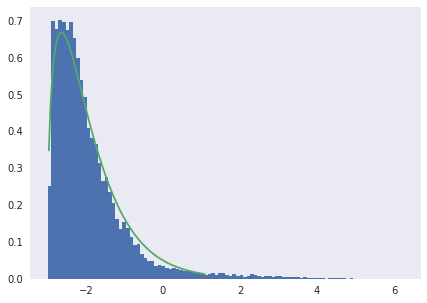

In [290]:
logrpkm_mean = np.array([np.mean(np.log10(np.maximum(a, 0.001))) for a in signals['exRNA_rpkm']])
logrpkm_mean_nonzero = logrpkm_mean[~np.isclose(logrpkm_mean, -3)]
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(logrpkm_mean_nonzero, bins=100, normed=True)
a, loc, scale = stats.gamma.fit(logrpkm_mean_nonzero, floc=-3.0)
x = np.linspace(stats.gamma.ppf(0.01, a, loc, scale),
                stats.gamma.ppf(0.99, a, loc, scale), 100)
ax.plot(x, stats.gamma.pdf(x, a, loc, scale))
print('a={}, loc={}, scale={}'.format(a, loc, scale))

In [293]:
print(np.median(logrpkm_mean_nonzero), stats.gamma.ppf(0.5, a, loc, scale))

-2.1864949484242455 -2.141907385694391


exRNA_heatmap.ipynb         rna_circle_plot.ipynb
exRNA_peak_calling.ipynb    rna_circle_plot.pdf
fourier_transform.ipynb     seaborn_examples.ipynb
histogram_matrix.txt        sklearn_datasets.ipynb
matplotlib_examples.ipynb   spline_transformation.ipynb
mixture_distribution.ipynb  vpython_examples.ipynb
piranha_distribution.ipynb


Text(0.5,0,'Log10(fragment length)')

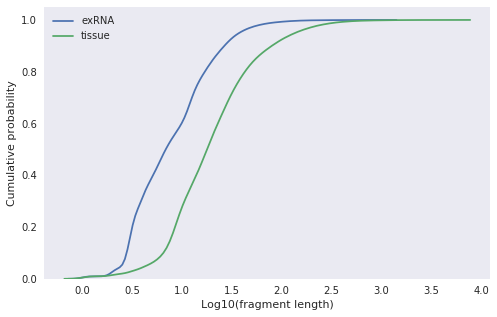

In [321]:
peaks_locations = {}
#fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig, ax = plt.subplots(figsize=(8, 5))
for i, dataset in enumerate(['exRNA', 'tissue']):
    df = pd.read_table('/home/shibinbin/projects/exRNA/output/call_peak/{}_rpkm.bed'.format(dataset), 
                                             header=None, names=['gene_id', 'start', 'end'])
    df['length'] = df['end'] - df['start']
    peaks_locations[dataset] = df
    sns.kdeplot(np.log10(df['length'].values), ax=ax, label=dataset, cumulative=True)
    #axes[i].hist(np.log10(df['length'].values), normed=True, bins=100)
ax.set_ylabel('Cumulative probability')
ax.set_xlabel('Log10(fragment length)')

In [319]:
sns.kdeplot?